In [77]:
import sys  

reload(sys)  
sys.setdefaultencoding('utf8')
# compile sample documents into a list
textFiles = ["ai.txt", "cs.txt", "csys.txt", "ec.txt", "rad.txt"]

In [78]:
import nltk
import string
from nltk.stem.porter import PorterStemmer
import codecs
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
wordnet_lemmatizer = WordNetLemmatizer()

token_dict = []
#stemmer = PorterStemmer()
stemmer = SnowballStemmer("english")
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        item = wordnet_lemmatizer.lemmatize(item)
        stemmed.append(item)
        #stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    filtered_words = [w for w in tokens if not w in stopwords.words('english')]
    stems = stem_tokens(filtered_words, stemmer)
    return stems

for file_name in textFiles:
    with codecs.open(file_name, "r",encoding='utf-8', errors='ignore') as f:  
        text = f.read().encode('utf-8').strip()
        text = text.replace('\r', ' ')
        text = text.replace('\n', ' ')
        lowers = text.lower().strip()
        no_punctuation = lowers.translate(None, string.punctuation)
        token_dict.append(no_punctuation)


In [79]:
token_dict[0][0:200]

'artificial intelligence ai is intelligence exhibited by machines in computer science an ideal intelligent machine is a flexible rational agent that perceives its environment and takes actions that max'

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(token_dict) #fit the vectorizer to synopses

(tfidf_matrix.shape)

(5, 7614)

In [81]:
terms = tfidf_vectorizer.get_feature_names()


In [82]:
terms

[u'0',
 u'0 1',
 u'0 1 arbitrary',
 u'0 1 logic',
 u'0 high',
 u'0 high current',
 u'0 lower',
 u'0 lower voltage',
 u'1',
 u'1 arbitrary',
 u'1 arbitrary ternary',
 u'1 logic',
 u'1 logic 0',
 u'1 referred',
 u'1 referred high',
 u'1 released',
 u'1 released simplified',
 u'16',
 u'16 64',
 u'16 64 254',
 u'16234',
 u'16234 1673',
 u'16234 1673 gottfried',
 u'1673',
 u'1673 gottfried',
 u'1673 gottfried leibniz',
 u'1820',
 u'1820 thomas',
 u'1820 thomas colmar',
 u'1822',
 u'1822 eventually',
 u'1822 eventually gave',
 u'1834',
 u'1834 le',
 u'1834 le year',
 u'1843',
 u'1843 translation',
 u'1843 translation french',
 u'1885',
 u'1885 herman',
 u'1885 herman hollerith',
 u'1895',
 u'1895 received',
 u'1895 received nobel',
 u'18f',
 u'18f 18ffdg',
 u'18f 18ffdg heart',
 u'18ffdg',
 u'18ffdg heart',
 u'18ffdg heart lung',
 u'18ffdg injected',
 u'18ffdg injected patient',
 u'1901',
 u'1901 filmscreen',
 u'1901 filmscreen radiography',
 u'1906',
 u'1906 invention',
 u'1906 invention le

In [83]:
from sklearn.cluster import KMeans

num_clusters = 3

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

#cluster assignment
clusters = km.labels_.tolist()
clusters

[1, 1, 0, 0, 2]

In [84]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print

<function print>

In [85]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [86]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}

#set up cluster names using a dict
textFiles = ["ai.txt", "cs.txt", "csys.txt", "ec.txt", "rad.txt"]
cluster_names = {0: "cluster 1", 
                 1: "cluster 2", 
                 2: 'cluster 3', 
                }

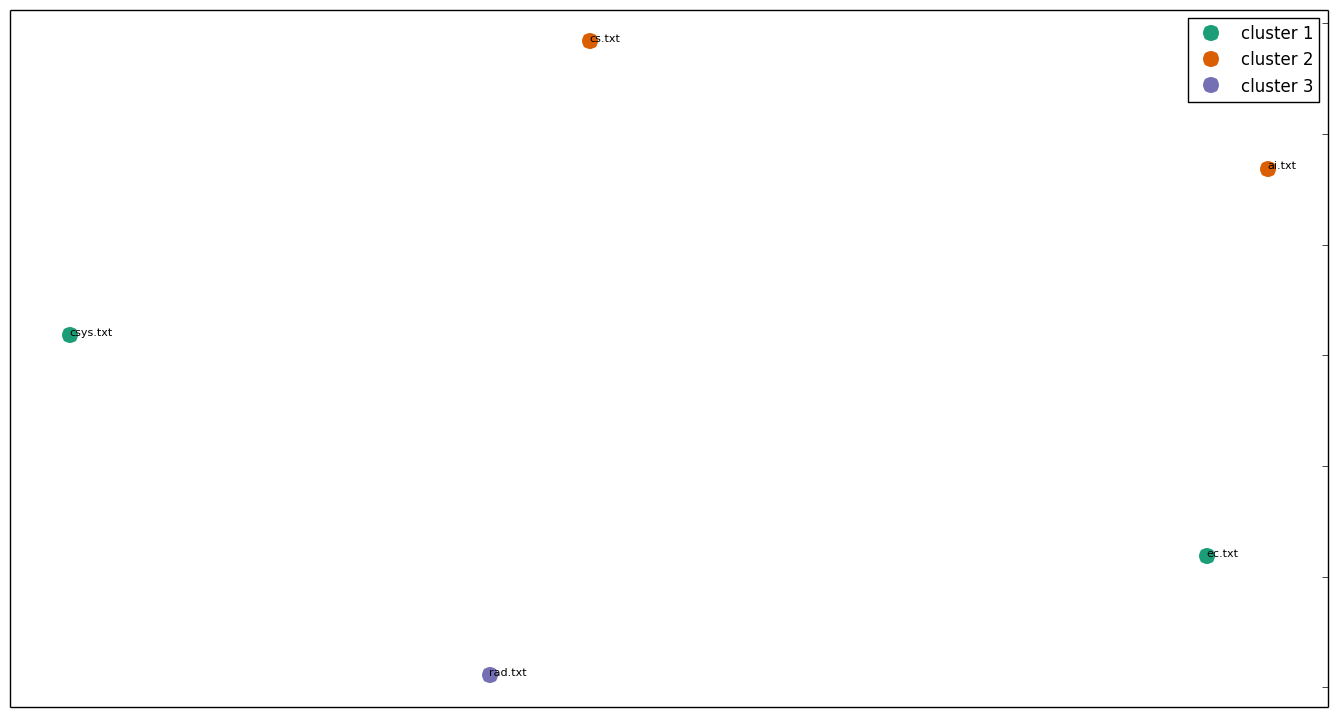

In [87]:
import pandas as pd
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=textFiles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#plt.savefig('clusters_small_noaxes.png', dpi=200)